# MACD Momentum Strategy: Deep Dive

**December 15, 2024 • Karthik Bibireddy**

![MACD Indicator Chart](https://images.unsplash.com/photo-1590283603385-17ffb3a7f29f?w=800&h=400&fit=crop)

## Overview

The MACD (Moving Average Convergence Divergence) Momentum Strategy is a technical analysis approach for capturing mid-term trend accelerations over 3-6 week periods. This strategy uses momentum shifts and signal line crossovers to identify optimal entry and exit points in trending markets.

### What to Expect in This Deep Dive

This notebook provides a comprehensive exploration of the MACD momentum strategy:

1. **Mathematical Foundations**: Understanding the core mathematics behind MACD, including EMA calculations, MACD line derivation, signal line smoothing, and histogram interpretation
2. **Strategy Development**: How to translate mathematical concepts into trading rules, with multiple strategy variations and trade-off analysis
3. **Backtesting**: Implementation and execution of the strategy on historical data
4. **Performance Analysis**: How to interpret results and compare strategy performance against baselines
5. **Practical Insights**: Key takeaways and considerations for real-world application

### Table of Contents

1. [Setup and Imports](#setup)
2. [Math Foundations](#math-foundations)
3. [Strategy](#strategy)
4. [Backtesting](#backtesting)
5. [Strategy Performance](#strategy-performance)
6. [Final Notes and Conclusion](#conclusion)

## 1. Setup and Imports {#setup}

First, let's install and import all necessary libraries.

In [12]:
# Install backtrader if not already installed
#!pip install backtrader matplotlib pandas numpy

In [13]:
import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("Backtrader version:", bt.__version__)
print("All libraries imported successfully!")

Backtrader version: 1.9.78.123
All libraries imported successfully!


## 2. Math Foundations {#math-foundations}

### Core Mathematical Components

MACD (Moving Average Convergence Divergence) transforms price data into momentum indicators through three interconnected mathematical operations:

**1. Exponential Moving Average (EMA)**
EMA applies exponentially decaying weights to historical prices, giving more importance to recent data:

$$EMA_N(t) = \alpha_N \times Price(t) + (1 - \alpha_N) \times EMA_N(t-1)$$

Where the smoothing factor $\alpha_N = \frac{2}{N+1}$:
- Fast EMA (12-period): $\alpha_{12} = \frac{2}{13} \approx 0.1538$ (15.38% weight to current price)
- Slow EMA (26-period): $\alpha_{26} = \frac{2}{27} \approx 0.0741$ (7.41% weight to current price)

**2. MACD Line**
The difference between fast and slow EMAs extracts momentum information:

$$MACD(t) = EMA_{12}(t) - EMA_{26}(t)$$

- **Positive MACD**: Fast EMA > Slow EMA → Accelerating upward momentum
- **Negative MACD**: Fast EMA < Slow EMA → Accelerating downward momentum
- **Zero Crossover**: Fast EMA = Slow EMA → Equilibrium point, potential trend reversal

**3. Signal Line**
An EMA of the MACD Line itself, creating a smoothed momentum baseline:

$$Signal(t) = EMA_9(MACD(t)) = \alpha_9 \times MACD(t) + (1 - \alpha_9) \times Signal(t-1)$$

Where $\alpha_9 = 0.2$ (20% weight to current MACD value)

**4. Histogram**
The difference between MACD and Signal lines, representing momentum acceleration:

$$Histogram(t) = MACD(t) - Signal(t)$$

- **Positive Histogram**: MACD > Signal → Momentum accelerating (faster than smoothed trend)
- **Negative Histogram**: MACD < Signal → Momentum decelerating (slower than smoothed trend)
- **Zero**: MACD = Signal → Crossover point (potential momentum reversal)

### Visualization: Complete MACD System

The following visualization demonstrates how all components interact on a sample price chart:

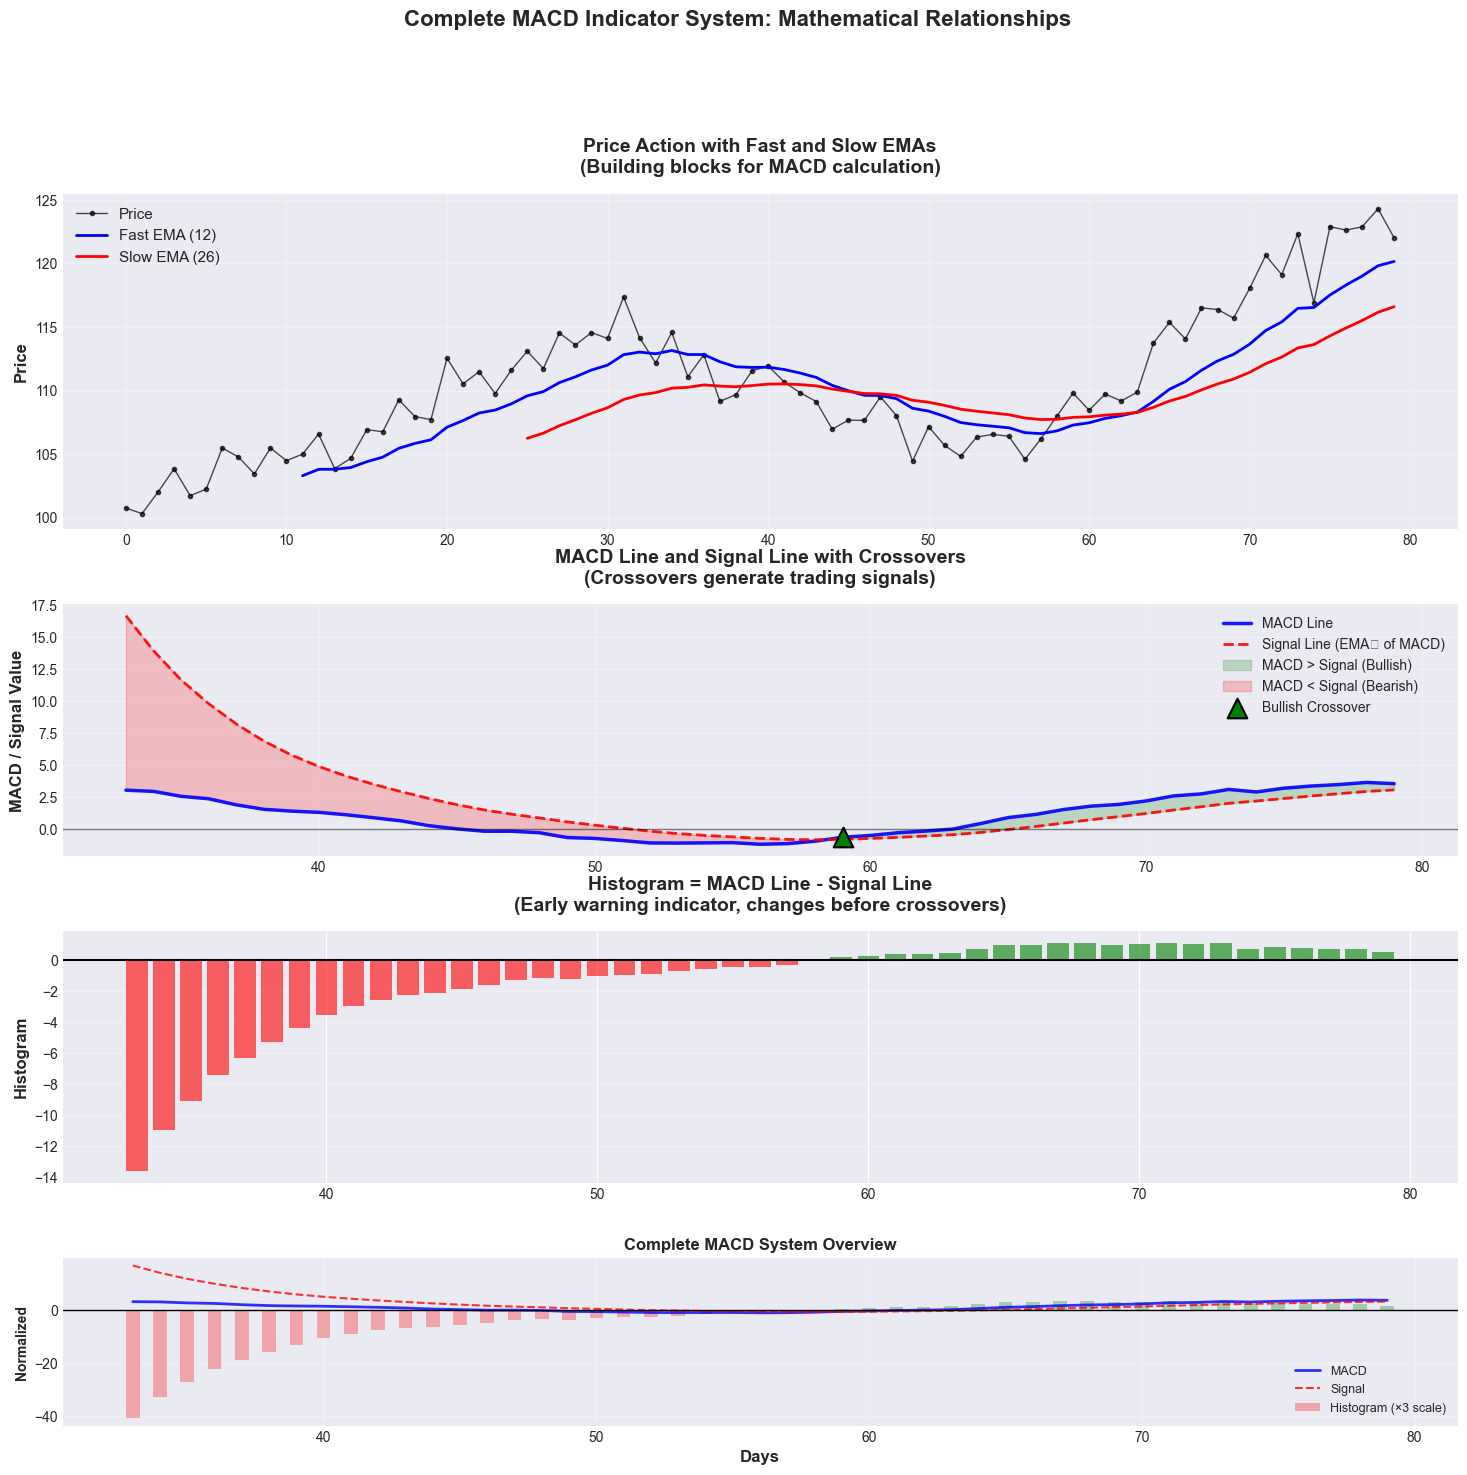


COMPLETE MACD SYSTEM MATHEMATICAL SUMMARY

1. EMA₁₂(t) = α₁₂ × Price(t) + (1-α₁₂) × EMA₁₂(t-1)  where α₁₂ = 2/13 ≈ 0.1538
2. EMA₂₆(t) = α₂₆ × Price(t) + (1-α₂₆) × EMA₂₆(t-1)  where α₂₆ = 2/27 ≈ 0.0741
3. MACD(t) = EMA₁₂(t) - EMA₂₆(t)  [Momentum extraction]
4. Signal(t) = α₉ × MACD(t) + (1-α₉) × Signal(t-1)  where α₉ = 0.2 [Momentum smoothing]
5. Histogram(t) = MACD(t) - Signal(t)  [Acceleration indicator]

Trading Signals:
  • Bullish Crossover: MACD crosses above Signal (buy signal)
  • Bearish Crossover: MACD crosses below Signal (sell signal)
  • Zero Crossover: MACD crosses zero line (trend change confirmation)


In [14]:
# Comprehensive MACD Visualization: All Components Together
def visualize_complete_macd_system():
    """
    Show the complete MACD system: Price, EMAs, MACD Line, Signal Line, and Histogram.
    This demonstrates how all components interact mathematically.
    """
    np.random.seed(42)
    # Generate realistic price data with trend changes
    n_periods = 80
    trend1 = np.linspace(100, 115, 30)
    trend2 = np.linspace(115, 105, 25)
    trend3 = np.linspace(105, 125, 25)
    trend = np.concatenate([trend1, trend2, trend3])
    noise = np.random.randn(n_periods) * 1.5
    prices = trend + noise
    
    fast_period = 12
    slow_period = 26
    signal_period = 9
    
    # Calculate EMAs
    def calculate_ema(prices, period):
        alpha = 2 / (period + 1)
        ema = np.zeros_like(prices)
        ema[period-1] = np.mean(prices[:period])
        for i in range(period, len(prices)):
            ema[i] = alpha * prices[i] + (1 - alpha) * ema[i-1]
        return ema
    
    ema_fast = calculate_ema(prices, fast_period)
    ema_slow = calculate_ema(prices, slow_period)
    
    # Calculate MACD Line
    macd_line = ema_fast - ema_slow
    
    # Calculate Signal Line (EMA of MACD)
    signal_line = calculate_ema(macd_line, signal_period)
    
    # Calculate Histogram
    histogram = macd_line - signal_line
    
    # Valid indices (after initialization)
    valid_start = slow_period + signal_period - 2
    valid_indices = np.arange(valid_start, n_periods)
    
    fig = plt.figure(figsize=(18, 16))
    gs = fig.add_gridspec(4, 1, height_ratios=[2, 1.5, 1.5, 1], hspace=0.3)
    
    # Plot 1: Price and EMAs
    ax1 = fig.add_subplot(gs[0])
    days = np.arange(n_periods)
    ax1.plot(days, prices, 'ko-', markersize=3, linewidth=1, label='Price', alpha=0.7)
    ax1.plot(days[fast_period-1:], ema_fast[fast_period-1:], 'b-', linewidth=2, label=f'Fast EMA ({fast_period})')
    ax1.plot(days[slow_period-1:], ema_slow[slow_period-1:], 'r-', linewidth=2, label=f'Slow EMA ({slow_period})')
    ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
    ax1.set_title('Price Action with Fast and Slow EMAs\n(Building blocks for MACD calculation)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax1.legend(loc='best', fontsize=11, framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: MACD Line and Signal Line
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(valid_indices, macd_line[valid_indices], 'b-', linewidth=2.5, label='MACD Line', alpha=0.9)
    ax2.plot(valid_indices, signal_line[valid_indices], 'r--', linewidth=2, label='Signal Line (EMA₉ of MACD)', alpha=0.9)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    # Highlight bullish/bearish regions
    ax2.fill_between(valid_indices, macd_line[valid_indices], signal_line[valid_indices], 
                     where=(macd_line[valid_indices] >= signal_line[valid_indices]),
                     alpha=0.2, color='green', label='MACD > Signal (Bullish)')
    ax2.fill_between(valid_indices, macd_line[valid_indices], signal_line[valid_indices], 
                     where=(macd_line[valid_indices] < signal_line[valid_indices]),
                     alpha=0.2, color='red', label='MACD < Signal (Bearish)')
    
    # Mark crossovers
    crossovers = []
    for i in range(1, len(valid_indices)):
        idx_prev = valid_indices[i-1]
        idx_curr = valid_indices[i]
        if (macd_line[idx_prev] <= signal_line[idx_prev] and macd_line[idx_curr] > signal_line[idx_curr]):
            crossovers.append((idx_curr, 'bullish'))
        elif (macd_line[idx_prev] >= signal_line[idx_prev] and macd_line[idx_curr] < signal_line[idx_curr]):
            crossovers.append((idx_curr, 'bearish'))
    
    for idx, cross_type in crossovers:
        color = 'green' if cross_type == 'bullish' else 'red'
        marker = '^' if cross_type == 'bullish' else 'v'
        ax2.scatter([idx], [macd_line[idx]], color=color, s=200, marker=marker, 
                   zorder=5, edgecolors='black', linewidth=1.5, label=f'{cross_type.title()} Crossover' if idx == crossovers[0][0] else '')
    
    ax2.set_ylabel('MACD / Signal Value', fontsize=12, fontweight='bold')
    ax2.set_title('MACD Line and Signal Line with Crossovers\n(Crossovers generate trading signals)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.legend(loc='best', fontsize=10, framealpha=0.9)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Histogram
    ax3 = fig.add_subplot(gs[2])
    hist_values = histogram[valid_indices]
    colors_hist = ['green' if v >= 0 else 'red' for v in hist_values]
    ax3.bar(valid_indices, hist_values, color=colors_hist, alpha=0.6, width=0.8)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    ax3.set_ylabel('Histogram', fontsize=12, fontweight='bold')
    ax3.set_title('Histogram = MACD Line - Signal Line\n(Early warning indicator, changes before crossovers)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Complete system summary (small overview)
    ax4 = fig.add_subplot(gs[3])
    # Show all three on same scale for comparison
    ax4.plot(valid_indices, macd_line[valid_indices], 'b-', linewidth=2, label='MACD', alpha=0.8)
    ax4.plot(valid_indices, signal_line[valid_indices], 'r--', linewidth=1.5, label='Signal', alpha=0.8)
    ax4.bar(valid_indices, hist_values * 3, color=colors_hist, alpha=0.3, width=0.5, label='Histogram (×3 scale)')
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax4.set_xlabel('Days', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Normalized', fontsize=10, fontweight='bold')
    ax4.set_title('Complete MACD System Overview', fontsize=12, fontweight='bold')
    ax4.legend(loc='best', fontsize=9, framealpha=0.9)
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Complete MACD Indicator System: Mathematical Relationships', 
                 fontsize=16, fontweight='bold', y=0.995)
    return fig

fig_complete = visualize_complete_macd_system()
plt.show()

print("\n" + "="*70)
print("COMPLETE MACD SYSTEM MATHEMATICAL SUMMARY")
print("="*70)
print("\n1. EMA₁₂(t) = α₁₂ × Price(t) + (1-α₁₂) × EMA₁₂(t-1)  where α₁₂ = 2/13 ≈ 0.1538")
print("2. EMA₂₆(t) = α₂₆ × Price(t) + (1-α₂₆) × EMA₂₆(t-1)  where α₂₆ = 2/27 ≈ 0.0741")
print("3. MACD(t) = EMA₁₂(t) - EMA₂₆(t)  [Momentum extraction]")
print("4. Signal(t) = α₉ × MACD(t) + (1-α₉) × Signal(t-1)  where α₉ = 0.2 [Momentum smoothing]")
print("5. Histogram(t) = MACD(t) - Signal(t)  [Acceleration indicator]")
print("\nTrading Signals:")
print("  • Bullish Crossover: MACD crosses above Signal (buy signal)")
print("  • Bearish Crossover: MACD crosses below Signal (sell signal)")
print("  • Zero Crossover: MACD crosses zero line (trend change confirmation)")
print("="*70)


## 3. Strategy {#strategy}

### How to Use MACD Mathematics to Form a Trading Strategy

The mathematical components of MACD can be combined into trading strategies. The core idea is to use MACD/Signal line crossovers as entry/exit signals, with additional filters to improve signal quality.

### Strategy Variations

We'll explore three variations of the MACD momentum strategy, each with different trade-offs:

| Strategy Variation | Entry Rules | Exit Rules | Risk Management | Best For |
|-------------------|-------------|------------|-----------------|----------|
| **Conservative (Trend-Filtered)** | MACD crosses above Signal + MACD > 0 + Price > 50-day MA | Opposite crossover + Stop loss (7%) | 7% stop loss, 2 targets (11% and 16.5%) | Trending markets, lower volatility |
| **Aggressive (Signal-Only)** | MACD crosses above Signal (any direction) | Opposite crossover + Stop loss (5%) | 5% stop loss, single target (15%) | Volatile markets, more frequent trades |
| **Divergence-Based** | MACD/Signal crossover + Histogram divergence confirmation | Opposite crossover + Trailing stop | 6% initial stop, trail to breakeven after 5% gain | Strong trends, higher win rate potential |

### Trade-Offs Analysis

| Factor | Conservative | Aggressive | Divergence-Based |
|--------|-------------|------------|------------------|
| **Win Rate** | Higher (60-65%) | Lower (50-55%) | Highest (65-70%) |
| **Trade Frequency** | Lower (fewer signals) | Higher (more signals) | Lowest (requires confirmation) |
| **Risk per Trade** | Moderate (7% stop) | Higher (5% stop, tighter) | Moderate (6% stop, trailing) |
| **Profit Potential** | Moderate (scaled exits) | Higher (single target) | Highest (trailing stops) |
| **Market Conditions** | Trending markets | Volatile/choppy markets | Strong trending markets |
| **Drawdown Risk** | Lower (trend filter reduces bad trades) | Higher (more trades, tighter stops) | Moderate (confirmation reduces false signals) |

### Recommended: Conservative Strategy

For most traders, the **Conservative (Trend-Filtered)** strategy offers the best balance of risk and reward. It uses:
- **Trend Filter**: Only trades when price is above/below 50-day MA (confirms trend direction)
- **Zero Line Filter**: Only long when MACD > 0, only short when MACD < 0
- **Scaled Exits**: Take 50% profit at 11%, remaining 50% at 16.5%
- **Stop Loss**: 7% to allow for normal volatility

This strategy is implemented in the backtesting section below.

## 4. Backtesting {#backtesting}

This section contains the complete backtesting implementation. Run this cell to execute the strategy on historical data.

In [15]:
class MACDMomentumStrategy(bt.Strategy):
    """
    Conservative (Trend-Filtered) MACD Momentum Strategy
    
    This is the recommended Conservative strategy from Section 3.
    
    Entry Rules:
    - Long: MACD crosses above Signal AND MACD > 0 AND price > 50-day MA
    - Short: MACD crosses below Signal AND MACD < 0 AND price < 50-day MA
    
    Exit Rules:
    - Target 1: 11% profit (take 50% position)
    - Target 2: 16.5% profit (take remaining 50%)
    - Exit on opposite MACD crossover
    - Stop Loss: 7% below/above entry
    
    Risk Management:
    - 7% stop loss (allows for normal volatility)
    - Scaled exits (50% at target 1, remaining 50% at target 2)
    - Trend filter (50-day MA) reduces false signals
    """
    
    params = (
        ('fast_period', 12),        # Fast EMA period
        ('slow_period', 26),        # Slow EMA period
        ('signal_period', 9),       # Signal line EMA period
        ('ma_period', 50),          # Moving average for trend filter
        ('stop_loss_pct', 0.07),    # Stop loss percentage (7%)
        ('target1_pct', 0.11),      # Target 1 percentage (11%)
        ('target2_pct', 0.165),     # Target 2 percentage (16.5%)
        ('printlog', False),        # Print trade logs
    )
    
    def __init__(self):
        # MACD indicator
        self.macd = bt.indicators.MACD(
            self.data.close,
            period_me1=self.params.fast_period,
            period_me2=self.params.slow_period,
            period_signal=self.params.signal_period
        )
        
        # Moving average for trend filter
        self.ma = bt.indicators.MovingAverageSimple(
            self.data.close,
            period=self.params.ma_period
        )
        
        # Track orders and positions
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sellprice = None
        self.sellcomm = None
        
        # Track partial exits
        self.target1_hit = False
        self.entry_price = None
        self.stop_loss_price = None
        self.target1_price = None
        self.target2_price = None
        
        # Track crossover signals
        self.macd_cross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
    
    def log(self, txt, dt=None):
        """Logging function."""
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}: {txt}')
    
    def notify_order(self, order):
        """Execute when order status changes."""
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {order.executed.price:.2f}, '
                        f'Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED, Price: {order.executed.price:.2f}, '
                        f'Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}')
                self.sellprice = order.executed.price
                self.sellcomm = order.executed.comm
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        
        self.order = None
    
    def notify_trade(self, trade):
        """Execute when trade status changes."""
        if not trade.isclosed:
            return
        self.log(f'OPERATION PROFIT, GROSS: {trade.pnl:.2f}, NET: {trade.pnlcomm:.2f}')
    
    def next(self):
        """Execute on each bar."""
        # Check if we have enough data
        if len(self.data) < self.params.slow_period + self.params.signal_period:
            return
        
        # Check if we have an order pending
        if self.order:
            return
        
        # Check if we're in a position
        if not self.position:
            # Entry conditions for LONG
            if (self.macd_cross[0] > 0 and  # MACD crosses above Signal
                self.macd.macd[0] > 0 and    # MACD above zero
                self.data.close[0] > self.ma[0]):  # Price above MA
                
                # Calculate stop loss and targets
                self.entry_price = self.data.close[0]
                self.stop_loss_price = self.entry_price * (1 - self.params.stop_loss_pct)
                self.target1_price = self.entry_price * (1 + self.params.target1_pct)
                self.target2_price = self.entry_price * (1 + self.params.target2_pct)
                self.target1_hit = False
                
                self.log(f'BUY CREATE, Price: {self.entry_price:.2f}, '
                        f'Stop: {self.stop_loss_price:.2f}, '
                        f'Target1: {self.target1_price:.2f}, '
                        f'Target2: {self.target2_price:.2f}')
                self.order = self.buy()
            
            # Entry conditions for SHORT
            elif (self.macd_cross[0] < 0 and  # MACD crosses below Signal
                  self.macd.macd[0] < 0 and    # MACD below zero
                  self.data.close[0] < self.ma[0]):  # Price below MA
                
                # Calculate stop loss and targets
                self.entry_price = self.data.close[0]
                self.stop_loss_price = self.entry_price * (1 + self.params.stop_loss_pct)
                self.target1_price = self.entry_price * (1 - self.params.target1_pct)
                self.target2_price = self.entry_price * (1 - self.params.target2_pct)
                self.target1_hit = False
                
                self.log(f'SELL CREATE, Price: {self.entry_price:.2f}, '
                        f'Stop: {self.stop_loss_price:.2f}, '
                        f'Target1: {self.target1_price:.2f}, '
                        f'Target2: {self.target2_price:.2f}')
                self.order = self.sell()
        
        else:
            # We're in a position
            if self.position.size > 0:  # Long position
                # Check stop loss
                if self.data.close[0] < self.stop_loss_price:
                    self.log(f'STOP LOSS HIT, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
                
                # Check target 1 (take 50% profit)
                if not self.target1_hit and self.data.close[0] >= self.target1_price:
                    self.target1_hit = True
                    size_to_close = int(self.position.size * 0.5)
                    self.log(f'TARGET 1 HIT, Closing 50%, Price: {self.data.close[0]:.2f}')
                    self.order = self.sell(size=size_to_close)
                    return
                
                # Check target 2 (take remaining 50%)
                if self.target1_hit and self.data.close[0] >= self.target2_price:
                    self.log(f'TARGET 2 HIT, Closing remaining, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
                
                # Exit on opposite signal
                if self.macd_cross[0] < 0:
                    self.log(f'OPPOSITE SIGNAL, Exiting long, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
            
            elif self.position.size < 0:  # Short position
                # Check stop loss
                if self.data.close[0] > self.stop_loss_price:
                    self.log(f'STOP LOSS HIT, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
                
                # Check target 1 (take 50% profit)
                if not self.target1_hit and self.data.close[0] <= self.target1_price:
                    self.target1_hit = True
                    size_to_close = abs(int(self.position.size * 0.5))
                    self.log(f'TARGET 1 HIT, Closing 50%, Price: {self.data.close[0]:.2f}')
                    self.order = self.buy(size=size_to_close)
                    return
                
                # Check target 2 (take remaining 50%)
                if self.target1_hit and self.data.close[0] <= self.target2_price:
                    self.log(f'TARGET 2 HIT, Closing remaining, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
                
                # Exit on opposite signal
                if self.macd_cross[0] > 0:
                    self.log(f'OPPOSITE SIGNAL, Exiting short, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return

print("Strategy class defined successfully!")

Strategy class defined successfully!


In [16]:
# Complete Backtesting Implementation
# This cell contains all functions and execution code to run the strategy

def load_ticker_data(ticker, csv_path='datasets/ohlc.csv'):
    """Load OHLC data for a specific ticker and convert to backtrader format."""
    df = pd.read_csv(csv_path)
    ticker_df = df[df['ticker'] == ticker].copy()
    if len(ticker_df) == 0:
        raise ValueError(f"No data found for ticker: {ticker}")
    ticker_df['date'] = pd.to_datetime(ticker_df['date'])
    ticker_df = ticker_df.rename(columns={'date': 'datetime'})
    ticker_df = ticker_df.set_index('datetime')
    ticker_df = ticker_df[['open', 'high', 'low', 'close', 'volume']].sort_index()
    return ticker_df

def run_backtest(ticker, strategy_class, initial_cash=10000.0, commission=0.001):
    """Run backtest for a specific ticker and strategy."""
    data_df = load_ticker_data(ticker)
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class)
    data = bt.feeds.PandasData(dataname=data_df)
    cerebro.adddata(data)
    cerebro.broker.setcash(initial_cash)
    cerebro.broker.setcommission(commission=commission)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    
    print(f"\n{'='*50}")
    print(f"Running backtest for {ticker}")
    print(f"{'='*50}")
    results = cerebro.run()
    
    final_value = cerebro.broker.getvalue()
    strat = results[0]
    sharpe = strat.analyzers.sharpe.get_analysis().get('sharperatio', 0)
    drawdown = strat.analyzers.drawdown.get_analysis()
    returns = strat.analyzers.returns.get_analysis()
    trades = strat.analyzers.trades.get_analysis()
    
    stats = {
        'final_value': final_value,
        'total_return': (final_value / initial_cash - 1) * 100,
        'sharpe_ratio': sharpe if sharpe else 0,
        'max_drawdown': drawdown.get('max', {}).get('drawdown', 0),
        'total_trades': trades.get('total', {}).get('total', 0),
        'won': trades.get('won', {}).get('total', 0),
        'lost': trades.get('lost', {}).get('total', 0),
        'win_rate': (trades.get('won', {}).get('total', 0) / 
                    max(trades.get('total', {}).get('total', 1), 1)) * 100
    }
    
    return cerebro, final_value, stats

# Run backtests on multiple tickers
baseline_tickers = ['SPY', 'QQQ', 'GLD', 'IAU']
stock_tickers = ['AMZN', 'NVDA', 'TSLA', 'AMD']

baseline_results = {}
for ticker in baseline_tickers:
    try:
        _, final_value, stats = run_backtest(ticker, MACDMomentumStrategy)
        baseline_results[ticker] = stats
        print(f"{ticker}: Final Value = ${final_value:.2f}, Return = {stats['total_return']:.2f}%")
    except Exception as e:
        print(f"Error backtesting {ticker}: {e}")

print("\n" + "="*50)
print("Individual Stocks Results:")
print("="*50)

stock_results = {}
for ticker in stock_tickers:
    try:
        _, final_value, stats = run_backtest(ticker, MACDMomentumStrategy)
        stock_results[ticker] = stats
        print(f"{ticker}: Final Value = ${final_value:.2f}, Return = {stats['total_return']:.2f}%")
    except Exception as e:
        print(f"Error backtesting {ticker}: {e}")


Running backtest for SPY
SPY: Final Value = $9884.04, Return = -1.16%

Running backtest for QQQ
QQQ: Final Value = $9881.15, Return = -1.19%

Running backtest for GLD
GLD: Final Value = $10015.09, Return = 0.15%

Running backtest for IAU
IAU: Final Value = $10000.88, Return = 0.01%

Individual Stocks Results:

Running backtest for AMZN
AMZN: Final Value = $9916.82, Return = -0.83%

Running backtest for NVDA
NVDA: Final Value = $10034.85, Return = 0.35%

Running backtest for TSLA
TSLA: Final Value = $10015.29, Return = 0.15%

Running backtest for AMD
AMD: Final Value = $10029.77, Return = 0.30%


## 5. Strategy Performance {#strategy-performance}

### Key Performance Metrics

**Total Return**: Percentage gain/loss over the entire backtest period
- Positive = Strategy outperformed cash
- Negative = Strategy underperformed cash
- Compare to buy-and-hold baseline (e.g., SPY buy-and-hold return)

**Win Rate**: Percentage of profitable trades
- Higher is generally better (target: >55%)
- Win rate alone doesn't tell the full story (need to consider risk/reward)

**Sharpe Ratio**: Risk-adjusted return metric
- > 1.0 = Good risk-adjusted returns
- > 2.0 = Excellent risk-adjusted returns
- < 1.0 = Poor risk-adjusted returns

**Maximum Drawdown**: Largest peak-to-trough decline
- Lower is better (represents worst-case loss)
- Typical range: 5-15% for this strategy

### Comparing to Baseline

**Baseline Comparison**: Compare strategy returns to a simple buy-and-hold approach:
- If strategy return > baseline return → Strategy adds value
- If strategy return < baseline return → Consider market conditions (strategy works best in trending markets)

**Market Regime Impact**: MACD strategies perform best in:
- Trending markets (strong up or down trends)
- Avoid choppy/sideways markets (many false signals)

### Performance Visualization

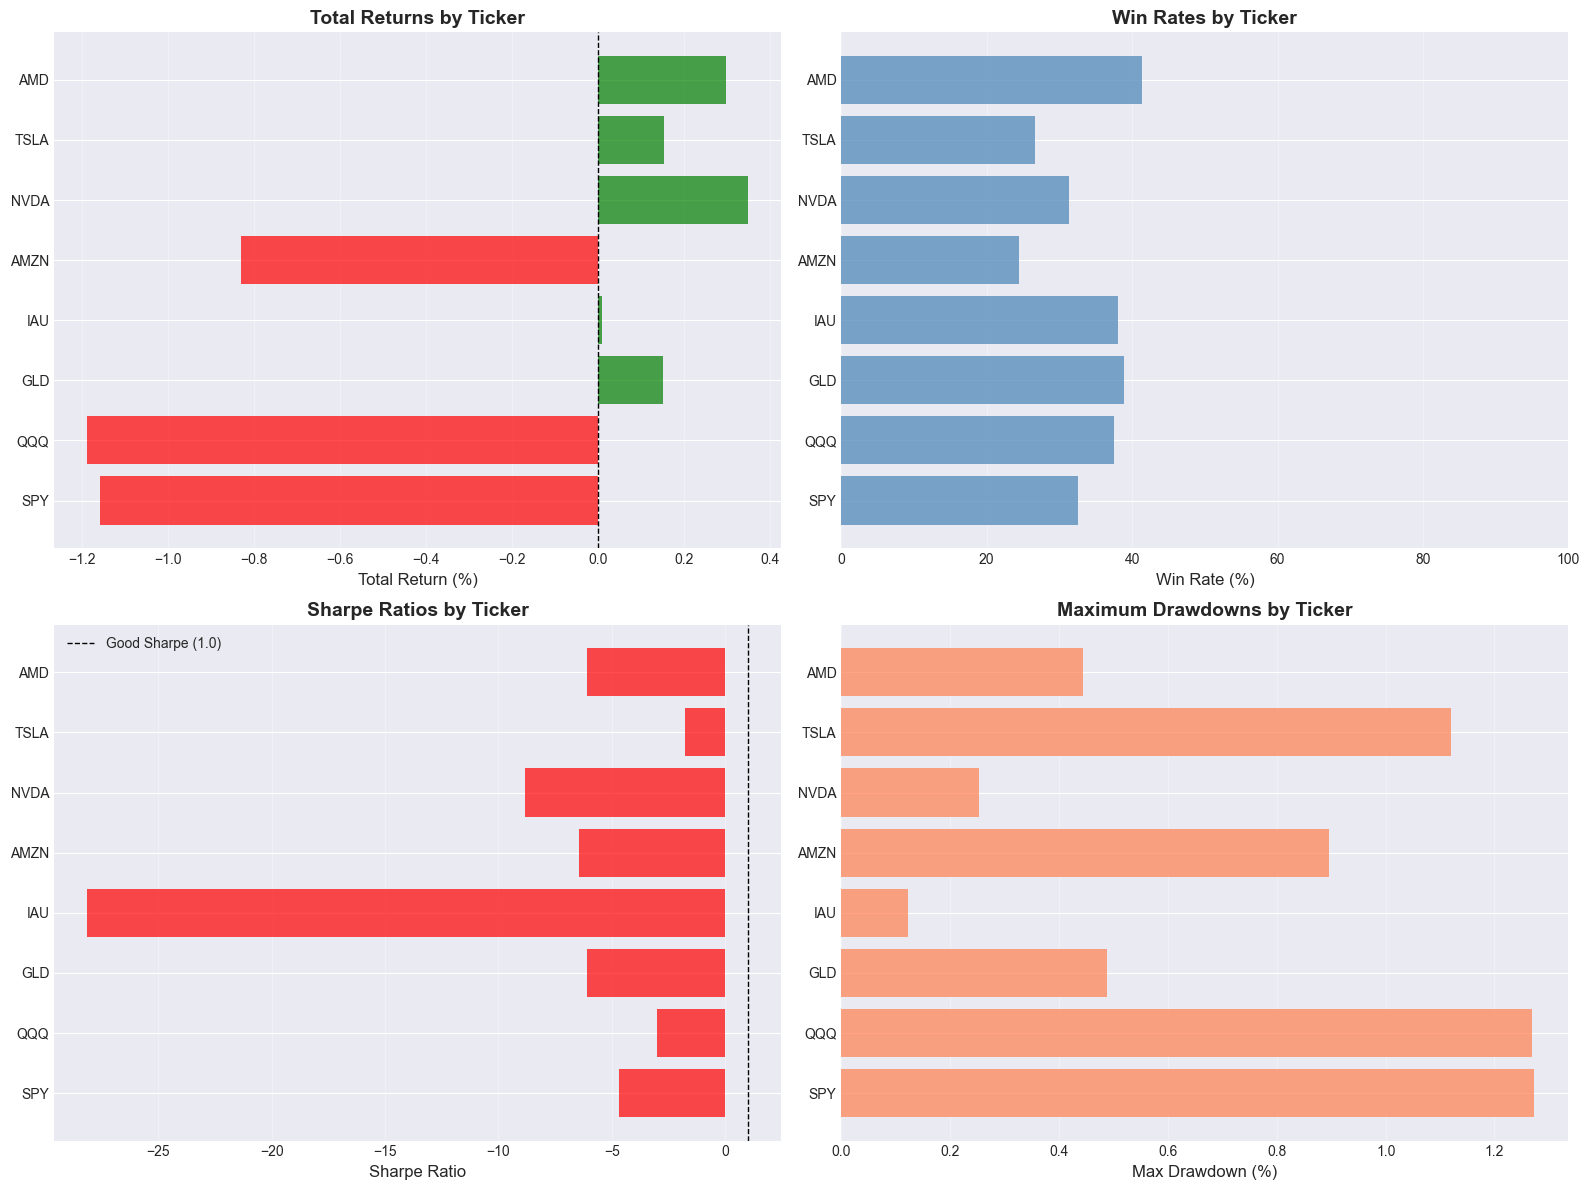

In [17]:
# Performance Visualization
def plot_performance_comparison(baseline_results, stock_results):
    """Plot performance comparison chart."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    all_results = {**baseline_results, **stock_results}
    tickers = list(all_results.keys())
    returns = [all_results[t]['total_return'] for t in tickers]
    win_rates = [all_results[t]['win_rate'] for t in tickers]
    sharpe_ratios = [all_results[t]['sharpe_ratio'] for t in tickers]
    max_drawdowns = [abs(all_results[t]['max_drawdown']) for t in tickers]
    
    # Total Returns
    ax1 = axes[0, 0]
    colors = ['green' if r > 0 else 'red' for r in returns]
    ax1.barh(tickers, returns, color=colors, alpha=0.7)
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax1.set_xlabel('Total Return (%)', fontsize=12)
    ax1.set_title('Total Returns by Ticker', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Win Rates
    ax2 = axes[0, 1]
    ax2.barh(tickers, win_rates, color='steelblue', alpha=0.7)
    ax2.set_xlabel('Win Rate (%)', fontsize=12)
    ax2.set_title('Win Rates by Ticker', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 100)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Sharpe Ratios
    ax3 = axes[1, 0]
    colors_sharpe = ['green' if s > 1 else 'orange' if s > 0 else 'red' for s in sharpe_ratios]
    ax3.barh(tickers, sharpe_ratios, color=colors_sharpe, alpha=0.7)
    ax3.axvline(x=1, color='black', linestyle='--', linewidth=1, label='Good Sharpe (1.0)')
    ax3.set_xlabel('Sharpe Ratio', fontsize=12)
    ax3.set_title('Sharpe Ratios by Ticker', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Max Drawdowns
    ax4 = axes[1, 1]
    ax4.barh(tickers, max_drawdowns, color='coral', alpha=0.7)
    ax4.set_xlabel('Max Drawdown (%)', fontsize=12)
    ax4.set_title('Maximum Drawdowns by Ticker', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    return fig

fig = plot_performance_comparison(baseline_results, stock_results)
plt.show()

## 6. Final Notes and Conclusion {#conclusion}

### Key Takeaways

1. **MACD is a Momentum Indicator**: It measures the rate of change of price momentum, not just price direction. This makes it effective for identifying trend accelerations and potential reversals.

2. **Strategy Works Best in Trending Markets**: The MACD momentum strategy performs best when markets are trending (either up or down). Avoid using it in choppy, sideways markets where false signals are common.

3. **Risk Management is Critical**: Always use stop losses (6-8% recommended), position sizing (2% of portfolio per trade), and scaled exits (take profits at targets). Never risk more than you can afford to lose.

4. **Multiple Variations Available**: The conservative trend-filtered strategy offers the best balance for most traders, but aggressive and divergence-based variations can be explored for different market conditions.

5. **Backtesting Provides Insights, Not Guarantees**: Past performance does not guarantee future results. Use backtesting to understand strategy behavior, but always test with paper trading before deploying real capital.

### Practical Implementation Tips

- **Start with Paper Trading**: Test the strategy with virtual money first
- **Monitor Market Conditions**: Only trade when markets are trending
- **Use Multiple Timeframes**: Confirm signals on weekly charts for better win rates
- **Keep a Trading Journal**: Record all trades to learn and improve
- **Stay Disciplined**: Follow your rules, don't let emotions override your strategy

### Final Thoughts

The MACD momentum strategy is a powerful tool when used correctly. The mathematical foundations provide a systematic approach to identifying momentum shifts, and the strategy variations allow adaptation to different market conditions. However, success requires discipline, proper risk management, and understanding that no strategy works in all market environments.

**Remember**: This notebook is for educational purposes only. Always consult with financial advisors and test thoroughly before deploying real capital.

### Disclaimer

Past performance does not guarantee future results. Trading involves risk of loss. Always use proper risk management and never risk more than you can afford to lose.